# Data Understanding

## Preparasi Modul

In [1]:
!pip install -q kaggle
!pip install scikit-learn

## Data Loading

In [3]:
import zipfile, os
import numpy as np
import itertools
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

In [5]:
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 89.4MB/s]


In [6]:
zip_ref = zipfile.ZipFile('indonesia-tourism-destination.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
rating = pd.read_csv('/content/tourism_rating.csv')
id = pd.read_csv('/content/tourism_with_id.csv')[['Place_Id',	'Place_Name',	'Description',	'Category',	'City',	'Price',	'Rating',	'Time_Minutes',	'Coordinate',	'Lat',	'Long']]
user = pd.read_csv('/content/user.csv')

## Univariate Exploratory Data Analysis


### Rating Data

In [8]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [9]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


### id Data

In [10]:
id.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [11]:
id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


### User Data

In [12]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [13]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


## Visualisasi Data

### Penggabungan data

In [14]:
tourism_all = np.concatenate((
    id.Place_Id.unique(),
    rating.Place_Id.unique()
))

tourism_all = np.sort(np.unique(tourism_all))
len(tourism_all)

437

In [15]:
all_tourism_rate = rating
all_tourism_rate

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [16]:
all_tourism = pd.merge(all_tourism_rate, id[['Place_Id',	'Place_Name', 'City','Category']], on='Place_Id', how='left')
all_tourism.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category
0,1,179,3,Candi Ratu Boko,Yogyakarta,Budaya
1,1,344,2,Pantai Marina,Semarang,Bahari
2,1,5,5,Atlantis Water Adventure,Jakarta,Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,Semarang,Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Yogyakarta,Budaya


### Grafik Category

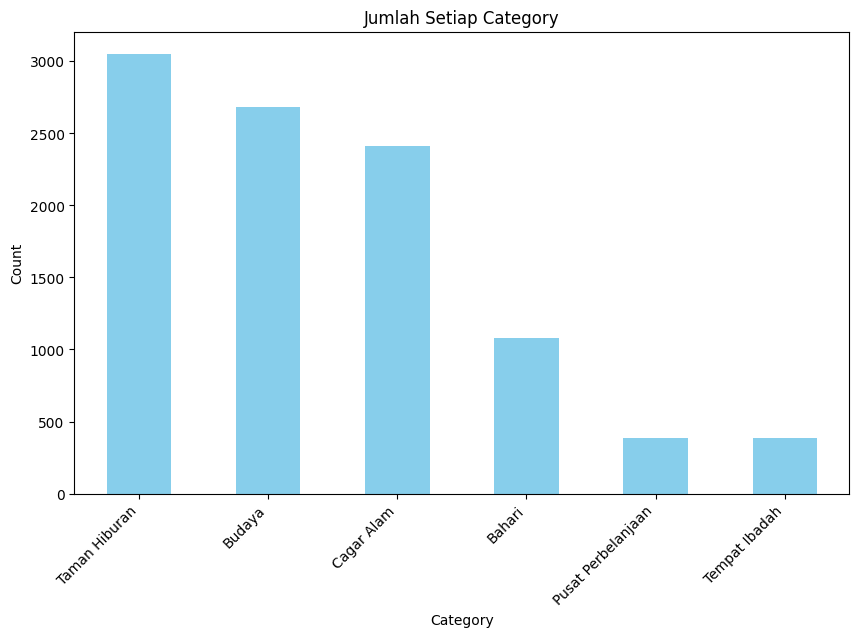

In [17]:
category_counts = all_tourism['Category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Jumlah Setiap Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

### Grafik City

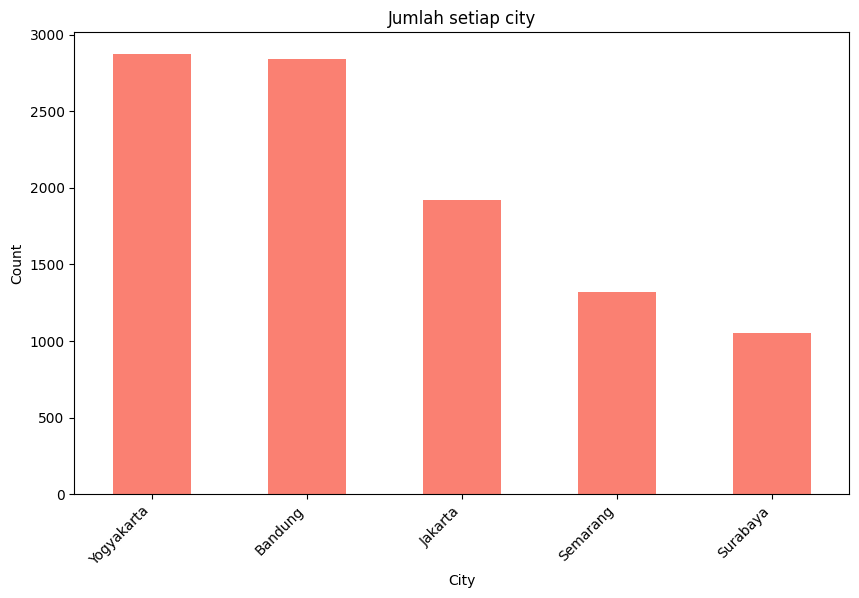

In [18]:
city_counts = all_tourism['City'].value_counts()

plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar', color='salmon')
plt.title('Jumlah setiap city')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

### Grafik Rating

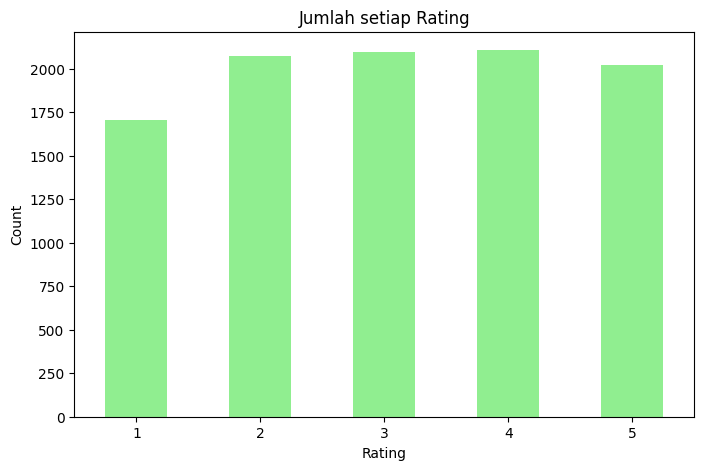

In [19]:
rating_counts = all_tourism['Place_Ratings'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
rating_counts.plot(kind='bar', color='lightgreen')
plt.title('Jumlah setiap Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Data Preparation

## Missing Value

In [20]:
all_tourism.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
Place_Name       0
City             0
Category         0
dtype: int64

## Duplicate

In [21]:
df_tourism = all_tourism.drop_duplicates('Place_Id')
df_tourism.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category
0,1,179,3,Candi Ratu Boko,Yogyakarta,Budaya
1,1,344,2,Pantai Marina,Semarang,Bahari
2,1,5,5,Atlantis Water Adventure,Jakarta,Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,Semarang,Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Yogyakarta,Budaya


## Konversi Menjadi list

In [22]:
user_id = df_tourism['User_Id'].tolist()
place_id = df_tourism['Place_Id'].tolist()
place_ratings = df_tourism['Place_Ratings'].tolist()
place_name = df_tourism['Place_Name'].tolist()
city = df_tourism['City'].tolist()
category = df_tourism['Category'].tolist()

In [23]:
df = pd.DataFrame({
    'user_id': user_id,
    'place_id': place_id,
    'place_ratings': place_ratings,
    'place_name': place_name,
    'city': city,
    'category': category
})
df.head()

,user_id,place_id,place_ratings,place_name,city,category
0,1,179,3,Candi Ratu Boko,Yogyakarta,Budaya
1,1,344,2,Pantai Marina,Semarang,Bahari
2,1,5,5,Atlantis Water Adventure,Jakarta,Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,Semarang,Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Yogyakarta,Budaya


## TF-IDF Vectorizer

In [24]:
tf = TfidfVectorizer()

tf.fit(df['category'])

tf.get_feature_names_out()

array(['alam', 'bahari', 'budaya', 'cagar', 'hiburan', 'ibadah',
       'perbelanjaan', 'pusat', 'taman', 'tempat'], dtype=object)

In [25]:
tfidf_matrix = tf.fit_transform(df['category'])

tfidf_matrix.shape

(437, 10)

In [26]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        ...,
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ]])

In [27]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=df.place_name
).sample(10, axis=1).sample(10, axis=0)

,perbelanjaan,alam,ibadah,budaya,hiburan,tempat,bahari,taman,cagar,pusat
place_name,,,,,,,,,,
Pantai Marina,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000
Chingu Cafe Little Seoul,0.000000,0.000000,0.0,0.0,0.707107,0.0,0.0,0.707107,0.000000,0.000000
The Great Asia Africa,0.000000,0.000000,0.0,0.0,0.707107,0.0,0.0,0.707107,0.000000,0.000000
Taman Hiburan Rakyat,0.000000,0.000000,0.0,0.0,0.707107,0.0,0.0,0.707107,0.000000,0.000000
Watu Mabur Mangunan,0.000000,0.707107,0.0,0.0,0.000000,0.0,0.0,0.000000,0.707107,0.000000
Kampung Korea Bandung,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Monumen Serangan Umum 1 Maret,0.000000,0.000000,0.0,0.0,0.707107,0.0,0.0,0.707107,0.000000,0.000000
Museum Sasmita Loka Ahmad Yani,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Jogja Exotarium,0.000000,0.000000,0.0,0.0,0.707107,0.0,0.0,0.707107,0.000000,0.000000


# Modeling and Result (Content Based Filtering)

## Cosine Similarity

In [28]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [29]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['place_name'], columns=df['place_name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (437, 437)


place_name,Surabaya Museum (Gedung Siola),Taman Bunga Cihideung,Wisata Kuliner Pecenongan,Kebun Bibit Wonorejo,Air Terjun Semirang
place_name,,,,,
Taman Bunga Cihideung,0.0,1.0,0.0,1.0,1.0
Jogja Bay Pirates Adventure Waterpark,0.0,0.0,0.0,0.0,0.0
Taman Vanda,0.0,0.0,0.0,0.0,0.0
Monumen Serangan Umum 1 Maret,0.0,0.0,0.0,0.0,0.0
Pantai Krakal,0.0,0.0,0.0,0.0,0.0
Pantai Drini,0.0,0.0,0.0,0.0,0.0
Brown Canyon,0.0,1.0,0.0,1.0,1.0
Pantai Ancol,0.0,0.0,0.0,0.0,0.0
Glamping Lakeside Rancabali,0.0,0.0,0.0,0.0,0.0


## Recommendation

In [44]:
def tourism_recommendations(place_name, similarity_data=cosine_sim_df, items=df[['place_name', 'category', 'city']], k=10):
    index = similarity_data.loc[:, place_name].to_numpy().argpartition(range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(place_name, errors='ignore')

    recommendations = pd.DataFrame(closest).merge(items).head(k)

    print(f"Apabila pengguna menyukai '{place_name}', 10 tempat berikut ini juga mungkin akan disukai: \n")
    return pd.DataFrame(closest).merge(items).head(k)

# Evaluation

## Top-N Recommendation (Candi Sewu)

In [45]:
tourism_recommendations("Candi Sewu")

Apabila pengguna menyukai 'Candi Sewu', 10 tempat berikut ini juga mungkin akan disukai: 



,place_name,category,city
0,Candi Ratu Boko,Budaya,Yogyakarta
1,Istana Negara Republik Indonesia,Budaya,Jakarta
2,Museum Nike Ardilla,Budaya,Bandung
3,Jalan Braga,Budaya,Bandung
4,Museum Benteng Vredeburg Yogyakarta,Budaya,Yogyakarta
5,Monumen Selamat Datang,Budaya,Jakarta
6,Museum Pendidikan Nasional,Budaya,Bandung
7,Taman Film,Budaya,Bandung
8,Monumen Yogya Kembali,Budaya,Yogyakarta
9,Tugu Muda Semarang,Budaya,Semarang


## Top-N Recommendation (NuArt Sclupture Park)

In [46]:
tourism_recommendations("NuArt Sculpture Park")

Apabila pengguna menyukai 'NuArt Sculpture Park', 10 tempat berikut ini juga mungkin akan disukai: 



,place_name,category,city
0,Bendung Lepen,Taman Hiburan,Yogyakarta
1,Kawasan Punclut,Taman Hiburan,Bandung
2,Atlantis Land Surabaya,Taman Hiburan,Surabaya
3,Bumi Perkemahan Cibubur,Taman Hiburan,Jakarta
4,Stone Garden Citatah,Taman Hiburan,Bandung
5,Blue Lagoon Jogja,Taman Hiburan,Yogyakarta
6,Trans Studio Bandung,Taman Hiburan,Bandung
7,Waterboom PIK (Pantai Indah Kapuk),Taman Hiburan,Jakarta
8,Hutan Pinus Pengger,Taman Hiburan,Yogyakarta
9,Sumur Gumuling,Taman Hiburan,Yogyakarta


## Top-N Recommendation (Pantai Marina)

In [47]:
tourism_recommendations("Pantai Marina")

Apabila pengguna menyukai 'Pantai Marina', 10 tempat berikut ini juga mungkin akan disukai: 



,place_name,category,city
0,Pantai Ngrenehan,Bahari,Yogyakarta
1,Pantai Parangtritis,Bahari,Yogyakarta
2,Pantai Pulang Sawal,Bahari,Yogyakarta
3,Pantai Krakal,Bahari,Yogyakarta
4,Pantai Drini,Bahari,Yogyakarta
5,Pantai Ancol,Bahari,Jakarta
6,Pulau Semak Daun,Bahari,Jakarta
7,Pantai Indrayanti,Bahari,Yogyakarta
8,Pantai Congot,Bahari,Yogyakarta
9,Pantai Sanglen,Bahari,Yogyakarta
